Filter jobs that succeeded

- "Calculating rate coefficient"

Failures in stderr.log

- "arc.exceptions.VectorsError: Could not calculate a dihedral angle for"
- "TypeError: can only concatenate str (not "int") to str" 

Exception in arc.log
- "Error: No conformer was found to be isomorphic with the 2D graph representation"
- "arc.exceptions.ReactionError", "is not atom balanced."


False Succeeded Jobs:

- "Warning: Could not determine a likely TS conformer for TS0", "All jobs for species TS0 successfully converged"

In [1]:
import re
import os
import pandas as pd

In [2]:
# Functions

def best_ts_method(data):
    for line in data:
        match = re.search(r'The method that generated the best TS guess and its output used for the optimization: (.*)', line)
        if match:
            return match.group(1)

    if not match:
        return None
    
def git_branch(data):
    """
    """
    for i, line in enumerate(data):
        if 'The current git' in line and 'ARC' in line:
            line = data[i + 3]
            match = re.search(r'the (.*) branch', line)
            if match:
                return match.group(1)
            else:
                return 'main'

def check_ts_all_fail(data):
    """
    """
    for line in data:
        if 'Heuristics did not find any successful TS guesses' in line:
            return True
    return False

def get_execution_time(data):
    """
    """
    for line in data:
        if "Total execution time:" in line:
            time_str = line.split("Total execution time:")[1].strip()
            return int(convert_to_seconds(time_str))
    return None

def convert_to_seconds(time_str):
    """
    Converts a time string in formats like 'HH:MM:SS' or '2.0 days, HH:MM:SS' to seconds.
    """
    try:
        # Split the string to check for days
        if "days" in time_str:
            days_part, time_part = time_str.split(" days, ")
            days = float(days_part)  # Convert days to a float in case of decimal
        else:
            time_part = time_str
            days = 0
        
        # Parse HH:MM:SS
        h, m, s = map(int, time_part.split(':'))
        
        # Convert to seconds
        total_seconds = int(days * 86400) + h * 3600 + m * 60 + s
        return total_seconds
    except ValueError:
        print(f"Invalid time format: {time_str}")
        return None
            

In [3]:
main_paths = {'Zeus':["/home/calvin/Dropbox/PersonalFolders/Calvin/HAb_Converged", "/home/calvin/Dropbox/PersonalFolders/Calvin/ZEUS_Failed",
                      "/home/calvin/Dropbox/PersonalFolders/Calvin/ZEUS_Converged"], 'Atlas': ["/home/calvin/Dropbox/PersonalFolders/Calvin/ATLAS_Converged", "/home/calvin/Dropbox/PersonalFolders/Calvin/ATLAS_Converged/NonRMG",
                                                                                                                                                        "/home/calvin/Dropbox/PersonalFolders/Calvin/ATLAS_Failed"]}


In [4]:
reaction_data = pd.DataFrame(columns=['reaction', 'server', 'converged', 'error', 'best_ts_method','branch', 'execution_time'])
for server, item in main_paths.items():
    for main_path in item:
        for folders in os.listdir(main_path):
            processed = False
            if os.path.isdir(os.path.join(main_path, folders)) and folders != 'NonRMG':
                    arc_log = os.path.join(main_path, folders, 'arc.log')
                    if os.path.exists(arc_log):
                        with open(arc_log, 'r') as f:
                            data = f.readlines()
                            processed = False
                            for line in reversed(data):
                                if 'Calculating rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders, 
                                            'server': server, 
                                            'converged': True, 
                                            'error': None,
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif "Warning: Could not determine a likely TS conformer for TS0" in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders, 
                                        'server': server, 
                                        'converged': False, 
                                        'error': 'Could not determine likely TS conformer',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'did not converge, cannot compute a rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders, 
                                            'server': server, 
                                            'converged': True, 
                                            'error': 'Reactant or Product did not converge, but TS did',
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif 'TS TS0 did not pass all checks, not computing rate coefficient' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': True,
                                            'error': 'TS did not pass all checks',
                                            'best_ts_method': best_ts_method(data),
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif 'Error: No conformer was found to be isomorphic with the 2D graph representation' in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False,
                                        'error': 'No conformer was found to be isomorphic with the 2D graph representation',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'opt did not pass isomorphism check' in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False,
                                        'error': 'Opt did not pass isomorphism check',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'Error: Could not troubleshoot geometry optimization for rmg_rxn_' in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False,
                                        'error': 'Could not troubleshoot geometry optimization of reactants or products',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'Warning: AutoTST subprocess did not give a successful return code' in line:
                                     if check_ts_all_fail(data):
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False,
                                            'error': 'Heuristics and AutoTST did not find any successful TS guesses',
                                            'best_ts_method': None,
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                elif 'are not atom balanced' in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False,
                                        'error': 'Reactants and products are not atom balanced',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                elif 'could not be atom mapped' in line:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False,
                                        'error': 'Could not atom map reactants and products - TS Error',
                                        'best_ts_method': None,
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)
                                    processed = True
                                    break
                                     
                    if not processed:
                        stderr_log_path = os.path.join(main_path, folders, "stderr.log") if os.path.exists(os.path.join(main_path, folders, "stderr.log")) else os.path.join(main_path, folders, "err.log")
                        if os.path.exists(stderr_log_path):
                            with open(stderr_log_path, 'r') as f:
                                error_data = f.readlines()
                                for line in error_data:
                                    if 'OSError: [Errno 12] Cannot allocate memory' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Memory Error',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif "['qsub: Illegal attribute or resource value select.mem']. Please check your submit script" in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'QSUB Illegal attribute or resource value select.mem',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'reactant_mol_combinations = list(itertools.product(*list(reactant.mol_list for reactant in reactants)))' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Reactant mol combinations - Heuristics',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'product_mol_combinations = list(itertools.product(*list(product.mol_list for product in products)))' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Product mol combinations - Heuristics',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'arc.exceptions.VectorsError: Could not calculate a dihedral angle' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Could not calculate dihedral angle',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif "ValueError: Could not find value" and "in the dictionary" in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Could not find value in dictionary',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'TypeError: zip argument #1 must support iteration' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Zip argument #1 must support iteration',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'ValueError: Could not interpret the identifier' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Could not interpret the identifier',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'OSError: [Errno 122] Disk quota exceeded' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Disk quota exceeded',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'OSError: [Errno 26] Text file busy' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'Text file busy',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif 'IndexError: list index out of range' in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': 'List index out of range',
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif "Error:  Couldn't find point group from symmetry output:" in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': True, 
                                            'error': "Symmetry GCLIB Error",
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break
                                    elif "TypeError: cannot unpack non-iterable int object" in line:
                                        reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                            'reaction': folders,
                                            'server': server,
                                            'converged': False, 
                                            'error': "Cannot unpack non-iterable int object",
                                            'branch': git_branch(data),
                                            'execution_time': get_execution_time(data)
                                        }])], ignore_index=True)
                                        processed = True
                                        break

                                    
                                if not processed:
                                    reaction_data = pd.concat([reaction_data, pd.DataFrame([{
                                        'reaction': folders,
                                        'server': server,
                                        'converged': False, 
                                        'error': 'No relevant information found',
                                        'branch': git_branch(data),
                                        'execution_time': get_execution_time(data)
                                    }])], ignore_index=True)

In [5]:
# We need to check that `converged` column, when False, has an `error` and if nto filled, show whcih ones
v = reaction_data[reaction_data['converged'] == True]


In [6]:
v

,reaction,server,converged,error,best_ts_method,branch,execution_time
0,rxn_1366,Zeus,True,None,heuristics,qchem,9755
1,rxn_1019,Zeus,True,None,heuristics,qchem,7697
3,rxn_1619,Zeus,True,None,heuristics,gaussian_unconverge_trsh,22960
6,rxn_1561,Zeus,True,None,heuristics,zeus_run,179718
7,rxn_1316,Zeus,True,None,autotst,qchem,62312
...,...,...,...,...,...,...,...
2631,rxn_3229,Atlas,True,None,heuristics,gauss_trsh_cleanup,8823
2635,rxn_3118,Atlas,True,None,heuristics,gauss_trsh_cleanup,5316
2639,rxn_3211,Atlas,True,None,heuristics,gauss_trsh_cleanup,9448
2640,rxn_3215,Atlas,True,None,heuristics,gauss_trsh_cleanup,5824


In [7]:
reaction_data[reaction_data['reaction'] == 'rmg_rxn_294']

,reaction,server,converged,error,best_ts_method,branch,execution_time
2094,rmg_rxn_294,Atlas,False,Could not determine likely TS conformer,None,gauss_trsh_cleanup,86461


In [7]:
reaction_data[reaction_data['error'] == 'No relevant information found']

,reaction,server,converged,error,best_ts_method,branch,execution_time
2654,rmg_rxn_966,Atlas,False,No relevant information found,NaN,crest,None
2659,rmg_rxn_961,Atlas,False,No relevant information found,NaN,crest,None
2671,rmg_rxn_955,Atlas,False,No relevant information found,NaN,crest,None
2688,rmg_rxn_967,Atlas,False,No relevant information found,NaN,crest,None
2705,rmg_rxn_964,Atlas,False,No relevant information found,NaN,crest,None
2818,rmg_rxn_968,Atlas,False,No relevant information found,NaN,crest,None
2830,rmg_rxn_954,Atlas,False,No relevant information found,NaN,crest,None
2848,rmg_rxn_965,Atlas,False,No relevant information found,NaN,crest,None


In [8]:
reaction_data
# Count False in converged column
reaction_data['converged'].value_counts()
print(reaction_data['error'].value_counts())

error
Could not determine likely TS conformer                                     447
No conformer was found to be isomorphic with the 2D graph representation    319
QSUB Illegal attribute or resource value select.mem                         129
Could not troubleshoot geometry optimization of reactants or products       111
Reactants and products are not atom balanced                                 79
Reactant or Product did not converge, but TS did                             77
Reactant mol combinations - Heuristics                                       66
Could not interpret the identifier                                           48
TS did not pass all checks                                                   29
Product mol combinations - Heuristics                                        28
Heuristics and AutoTST did not find any successful TS guesses                 9
No relevant information found                                                 8
Could not atom map reactants and p

In [9]:
error_summary = (
    reaction_data.groupby('error')
    .agg({'branch': lambda x: x.unique().tolist(), 'error': 'count'})
    .rename(columns={'error': 'count'})
)
print(error_summary)


                                                                                               branch  \
error                                                                                                   
Could not atom map reactants and products - TS ...                                        [crest_nmd]   
Could not calculate dihedral angle                                            [crest_debug_statement]   
Could not determine likely TS conformer             [qchem, gaussian_unconverge_trsh, heurist_impr...   
Could not find value in dictionary                                                            [crest]   
Could not interpret the identifier                                               [gauss_trsh_cleanup]   
Could not troubleshoot geometry optimization of...          [crest, crest_debug_statement, crest_nmd]   
Disk quota exceeded                                                              [gauss_trsh_cleanup]   
Heuristics and AutoTST did not find any success...     

In [10]:
t = reaction_data[reaction_data['branch'] == 'crest_debug_statement']

In [11]:
t

,reaction,server,converged,error,best_ts_method,branch,execution_time
1389,rmg_rxn_16332,Zeus,False,No conformer was found to be isomorphic with t...,None,crest_debug_statement,10846
1391,rmg_rxn_16518,Zeus,False,No conformer was found to be isomorphic with t...,None,crest_debug_statement,1305
1393,rmg_rxn_16418,Zeus,False,No conformer was found to be isomorphic with t...,None,crest_debug_statement,11311
1395,rmg_rxn_16384,Zeus,False,No conformer was found to be isomorphic with t...,None,crest_debug_statement,12140
1397,rmg_rxn_16506,Zeus,False,QSUB Illegal attribute or resource value selec...,NaN,crest_debug_statement,None
...,...,...,...,...,...,...,...
2867,rmg_rxn_1282,Atlas,False,Reactants and products are not atom balanced,None,crest_debug_statement,None
2868,rmg_rxn_1311,Atlas,False,Reactants and products are not atom balanced,None,crest_debug_statement,None
2871,rmg_rxn_1310,Atlas,False,Reactants and products are not atom balanced,None,crest_debug_statement,None
2874,rmg_rxn_1297,Atlas,False,Reactants and products are not atom balanced,None,crest_debug_statement,None


In [12]:
reaction_data[reaction_data['branch'].isnull()]

,reaction,server,converged,error,best_ts_method,branch,execution_time


branch
qchem                          1117
gauss_trsh_cleanup              649
crest_debug_statement           456
crest                           437
crest_nmd                        93
gaussian_unconverge_trsh         36
main                             33
heurist_impr                     21
debug_statement                  16
gauss_conformer_comb             14
zeus_run                          4
(HEAD detached at 7b8e561d)       3
Name: count, dtype: int64


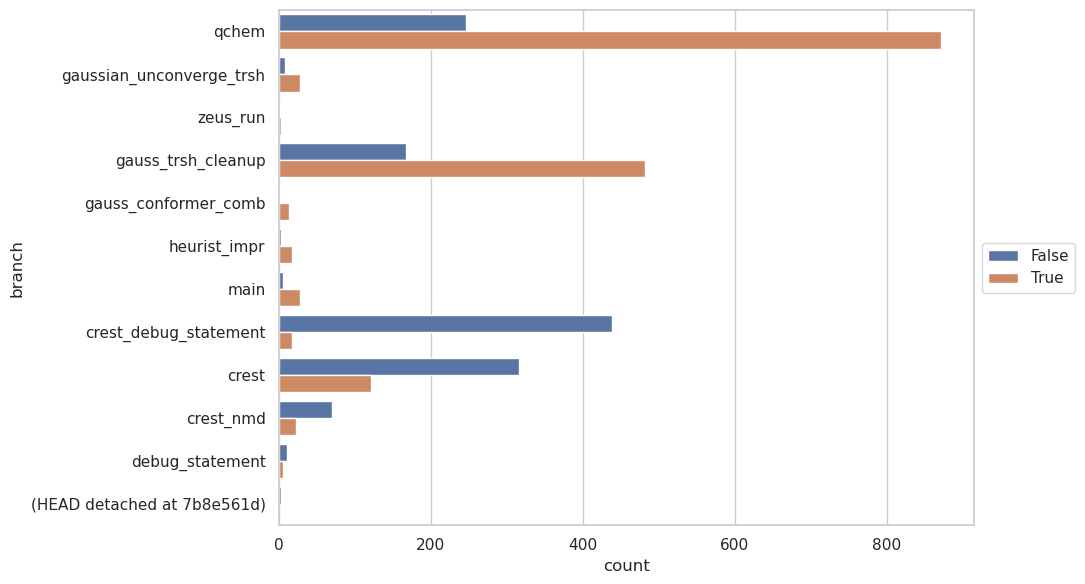

In [13]:
# Get unique branch names
reaction_data['branch'].unique()
print(reaction_data['branch'].value_counts())

# Get unique branch names and see the counts of how many failed against each branch
reaction_data.groupby(['branch', 'converged']).size()

# Let's plot the data
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Plot branch fails and successes (horizontal orientation)
sns.countplot(data=reaction_data, y='branch', hue='converged', orient='h')
# Adjust spacing if necessary
plt.tight_layout()
# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [14]:
reaction_data.query("error == 'Could not determine likely TS conformer' and branch == 'qchem'")


,reaction,server,converged,error,best_ts_method,branch,execution_time
2,rxn_1098,Zeus,False,Could not determine likely TS conformer,None,qchem,5961
4,rxn_156,Zeus,False,Could not determine likely TS conformer,None,qchem,66983
5,rxn_819,Zeus,False,Could not determine likely TS conformer,None,qchem,31981
8,rxn_177,Zeus,False,Could not determine likely TS conformer,None,qchem,7050
15,rxn_65,Zeus,False,Could not determine likely TS conformer,None,qchem,2010
...,...,...,...,...,...,...,...
1343,rxn_122,Zeus,False,Could not determine likely TS conformer,None,qchem,13921
1362,rxn_320,Zeus,False,Could not determine likely TS conformer,None,qchem,3215
1370,rxn_302,Zeus,False,Could not determine likely TS conformer,None,qchem,9890
1372,rxn_728,Zeus,False,Could not determine likely TS conformer,None,qchem,390013


In [15]:
reaction_data[reaction_data['error'].isnull() & reaction_data['converged'] == True]['execution_time'].mean() / 3600

np.float64(8.24347027907321)

In [16]:
# Average the execution time for each server
reaction_data[reaction_data['converged'] == True].groupby('server')['execution_time'].mean()
# Convert to hours from seconds and print the  number of jobs converged for each server

result = (
    reaction_data[reaction_data['converged'] == True]
    .groupby('server')['execution_time']
    .agg(mean_hours=lambda x: x.mean() / 3600, count='count')
)
print(result)


        mean_hours  count
server                   
Atlas    14.971571    385
Zeus      6.203381   1223


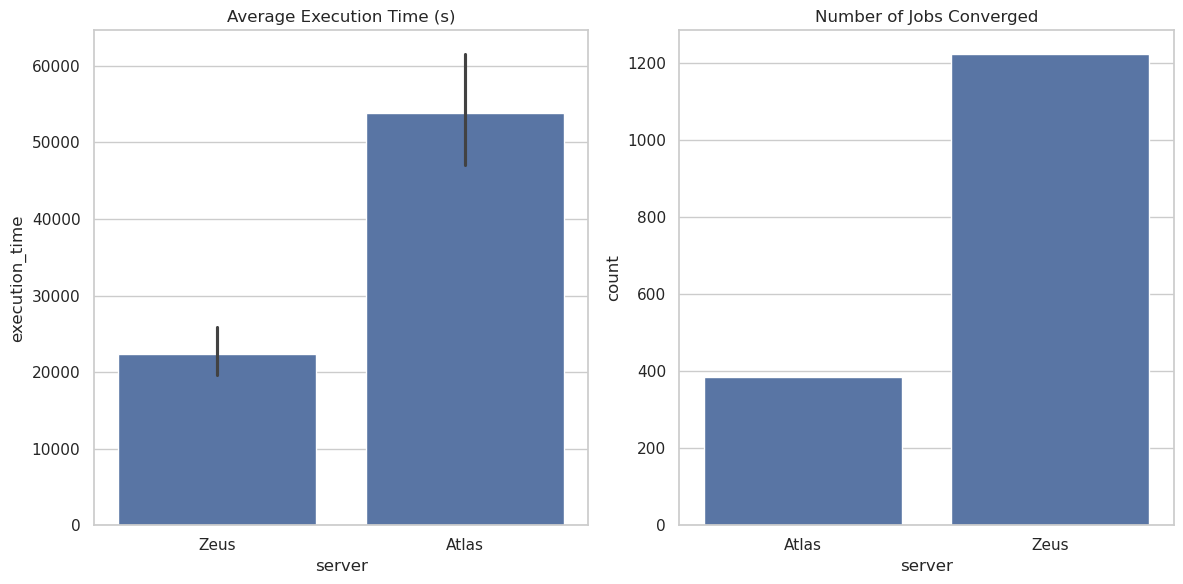

In [17]:
# Graph the average execution time for each server and the number of jobs converged
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=reaction_data[reaction_data['converged'] == True], x='server', y='execution_time', ax=ax[0])
ax[0].set_title('Average Execution Time (s)')
sns.barplot(data=result, x=result.index, y='count', ax=ax[1])
ax[1].set_title('Number of Jobs Converged')
plt.tight_layout()
plt.show()

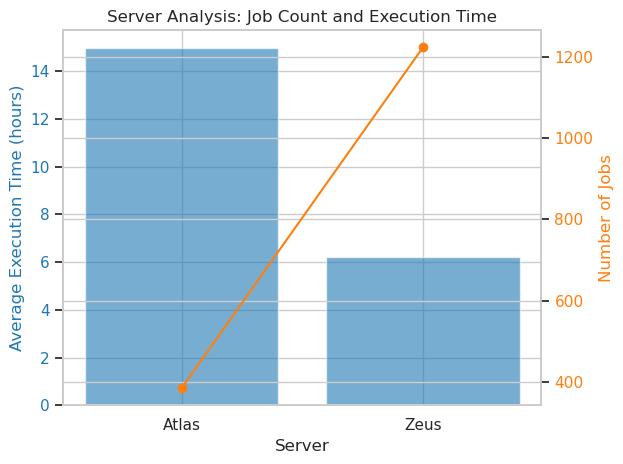

In [18]:
import matplotlib.pyplot as plt

# Assuming `result` is the DataFrame from the previous step
servers = result.index
mean_hours = result['mean_hours']
job_counts = result['count']

fig, ax1 = plt.subplots()

# Plot the average execution time on the first Y-axis
ax1.set_xlabel('Server')
ax1.set_ylabel('Average Execution Time (hours)', color='tab:blue')
ax1.bar(servers, mean_hours, color='tab:blue', alpha=0.6, label='Avg Execution Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second Y-axis for the number of jobs
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Jobs', color='tab:orange')
ax2.plot(servers, job_counts, color='tab:orange', marker='o', label='Job Count')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title
plt.title('Server Analysis: Job Count and Execution Time')

# Show the plot
fig.tight_layout()
plt.show()


In [19]:
reaction_data.to_csv('reaction_data.csv', index=False)